In [ ]:
# default_exp data_processing
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device mps
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 02d Flow Datasets
> Here be the tailored datasets for FRED! In addition to storing points, we must store a graph, and intelligently sample from the graph so that batches preserve 'flow neighborhoods'

As previously listed, this is our preprocessing pipeline.

0. Turn data to torch tensors
1. Build graph from data, using flashlight kernel
	1. Estimate best parameters for kernel selection
2. Take diffusion map on data (or any ‘best guess embedding’) we want to penalize against. (Can be done on CPU or GPU). Would likely use established methods, like PHATE, tSNE, node2vec.
	1. Visualize embedding
3. Find flow neighborhoods of data (possibly at multiple scales)
4. **Break data into batches (both affinity matrix of batches and points in batches).**
5. **Return `Dataloader` with minibatch `X` and subgraph `A` of each batch.**


0-3 are handled by separate functions. This notebook calls upon these functions, and implements the machinery for 4 and 5

# Two Types of Data
FRED can operate on both directed graphs (assumed to be sampled from a manifold with flow, ala the "Manifold with Flow" hypothesis) and pointclouds with associated velocity vectors (like RNA velocity single cell data). Each type is processed differently, and requires a different dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from FRED.data_processing import flashlight_affinity_matrix, diffusion_map_from_affinities, flow_neighbors
class ManifoldWithVectorField(Dataset):
    """
    Dataset object to be used with FRED for pointcloud and velocity input data.
    Takes np.arrays for X (points) and velocities (velocity vectors per point).
    For each item retrieved, returns a neighborhood around that point (based on local euclidean neighbors) containing local affinities

    """
    def __init__(self, X, velocities, sigma="automatic", prior_embedding = "diffusion map", t_dmap = 1, dmap_coords_to_use = 2, n_neighbors = 5, minibatch_size = 100, nbhd_strategy = "flow neighbors"):
        # Step 0: Convert data into tensors
        self.X = torch.tensor(X)
        self.velocities = torch.tensor(velocities)
        self.n_neighbors = n_neighbors
        self.n_nodes = self.X.shape[0]
        self.minibatch_size = minibatch_size
        # Step 1. Build graph on input data, using flashlight kernel
        self.A = flashlight_affinity_matrix(self.X, self.velocities, sigma = sigma)
        self.P_graph = F.normalize(self.A, p=1, dim=1)
        # visualize affinity matrix
        plt.imshow(self.A.numpy())
        # Step 2. Take a diffusion map of the data
        if prior_embedding == "diffusion map":
            P_graph_symmetrized = self.P_graph + self.P_graph.T
            diff_map = diffusion_map_from_affinities(
                P_graph_symmetrized, t=t_dmap, plot_evals=False
            )
            self.diff_coords = diff_map[:, :dmap_coords_to_use]
            self.diff_coords = self.diff_coords.real
            self.diff_coords = torch.tensor(self.diff_coords.copy()).float().to(device)
            self.precomputed_distances = torch.cdist(self.diff_coords, self.diff_coords)
            # scale distances between 0 and 1
            self.precomputed_distances = 2 * (
                self.precomputed_distances / torch.max(self.precomputed_distances)
            )
            self.precomputed_distances = (
                self.precomputed_distances.detach()
            )  # no need to have gradients from this operation
        # Step 3: This returns a sparse representation of the flow neighborhoods, in the form of two tensors: row, col. The numbers in row specify the index, and the adjacent entries in col are the neighbors of that index.
        if nbhd_strategy == "flow neighbors":
            self.neighborhoods = flow_neighbors(self.n_nodes, self.P_graph, self.n_neighbors)
    def neighbors_from_point(self, idx):
        # Returns list of idxs of neighbors of the given idx
        row, col = self.neighborhoods
        idxs = torch.squeeze(torch.nonzero(row == idx))
        return col[idxs]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        nbhd_idxs = self.neighbors_from_point(idx)
        random_idxs = torch.tensor(np.random.choice(np.arange(self.n_nodes), size=(self.minibatch_size))).long()
        minibatch_idxs = torch.concat([nbhd_idxs, random_idxs])
        # Compute miniature diffusion matrix
        A_batch = self.A[minibatch_idxs][:,minibatch_idxs]
        P_batch = F.normalize(A_batch, p=1, dim=1)
        # Get actual points
        X_batch = X[minibatch_idxs]
        # Embed these into a dictionary for easy cross reference
        return_dict = {
            "P":P_batch,
            "X":X_batch,
            "num flow neighbors":self.n_neighbors
        }
        return return_dict

## Testing

In [ ]:
from FRED.datasets import directed_swiss_roll_delayed
X, flow, labels = directed_swiss_roll_delayed(num_nodes=1000)

Set sigma =  2.3770845419489475


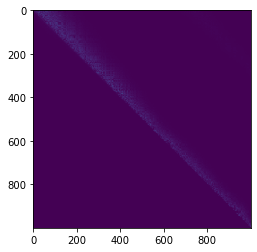

In [ ]:
ds = ManifoldWithVectorField(X, flow)

In [ ]:
for data in ds:
    print(data)

AttributeError: 'ManifoldWithVectorField' object has no attribute 'nu'